# Word Cloud Generator

## Setting Enviroment

In [1]:
# Import Python Stuff
import re
import numpy as np
import pandas as pd
from collections import Counter

# Import Python Word Cloud Stuff
from PIL import Image
import matplotlib_venn_wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Import GCP Stuff
from google.cloud import storage 
from google.cloud.storage.blob import Blob

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
  .builder \
  .master('yarn') \
  .appName('spark-bigquery-demo') \
  .getOrCreate()

In [3]:
bucket = "big-data-yelp"
spark.conf.set('temporaryGcsBucket', bucket)

## Loading Data

In [4]:
# Loading Reviews
table_re = 'red-formula-339716:gfds.yelp_review'
df_re = spark.read.format('bigquery').option('table', table_re).load()

In [5]:
# Loading Business
table = 'red-formula-339716:gfds.yelp_business_basicdata'
df_b = spark.read.format('bigquery').option('table', table).load()

In [6]:
df_b = df_b.select('business_id' ,'state')
df_re = df_re.select('stars', 'text', 'business_id')

In [7]:
dfj = df_re.join(df_b, ['business_id'], "inner")

In [8]:
dfj = dfj.where(dfj.state == "OH")

## Word Cloud Data Prep

In [9]:
dfj_five = dfj.where(dfj.stars == 5)
dfj_one = dfj.where(dfj.stars == 1)

In [10]:
pd_five = dfj_five.sample(False, 0.1).toPandas()
pd_one = dfj_one.sample(False, 0.2).toPandas()

In [11]:
pd_five.head()

,business_id,stars,text,state
0,x381VbHu4cUVKvos_SKKhQ,5.0,"Time after time they amaze me. Freshest food, ...",OH
1,rBhnjbnAdAFJJIR-6-yXXQ,5.0,This is some of the best food I've ever had. ...,OH
2,uPP0lRyQF98TQKfGDLY8NA,5.0,Such a cool spot in the short north. If you do...,OH
3,7fw5fqjoXsrJRLGleRTjOw,5.0,"The best gyros in town, in my opinion. Their ...",OH
4,l6QlIPwdJ-WEcAvoZzOSFw,5.0,Crisp pizza that's fully customized. Think of ...,OH


In [12]:
pd_one.head()

,business_id,stars,text,state
0,zkJtBNFGZmzWafbGSnQ3zw,1.0,Food is pathetic .. khasta kachori and sev poo...,OH
1,c_HtQ9dcrzPUznE_lUP6vg,1.0,"Okay, here is the REAL review of La Fogata or,...",OH
2,dYhGXeMDkat0i2ZJiN-ZfQ,1.0,I had a long day at work decided to go here. I...,OH
3,ui5cf8OXh1b9E6KGgN62sg,1.0,We went here several months ago and the servic...,OH
4,AmV3T-mYDGMz-KbqYZAudQ,1.0,I had high hopes for a new eating place in the...,OH


In [13]:
# Clean text and tokenlize
btext = re.findall(r'[A-Za-z]+', ' '.join(pd_one['text']).lower())
gtext = re.findall(r'[A-Za-z]+', ' '.join(pd_five['text']).lower())
alltext = btext + gtext

# Count it
bcount = Counter(btext)
gcount = Counter(gtext)
allcount = Counter(alltext)

# Get frequency
btotal = sum(bcount.values())
bfreq_percentage = {k: v/btotal for k, v in bcount.items()}
gtotal = sum(bcount.values())
gfreq_percentage = {k: v/gtotal for k, v in gcount.items()}
alltotal = sum(allcount.values())
allfreq_percentage = {k: v/gtotal for k, v in allcount.items()}

# Get good and bad review words
bset = set(bfreq_percentage.keys())
gset = set(gfreq_percentage.keys())

allset = bset & gset
gnbset = gset - bset
bngset = bset - gset

In [14]:
# Match word and frequency
gnbdict = {}
for i in gnbset:
    gnbdict[i] = gfreq_percentage[i]
    
bngdict = {}
for i in bngset:
    bngdict[i] = bfreq_percentage[i]
    
alldict = {}
for i in allset:
    alldict[i] = allfreq_percentage[i]

In [15]:
# Stopwords
stopwords = set(STOPWORDS)
stopwords.update(['didn', 'go', 's', 't', 'go', 've', 'd', 'm', 'us', 'will', 're', 'got', 'say', 'one'])
for key in stopwords:
  if key in gnbdict:
     del gnbdict[key]
for key in stopwords:
  if key in bngdict:
     del bngdict[key]
for key in stopwords:
  if key in alldict:
     del alldict[key]

## Loading Masks From GCP Storage

In [16]:
storage_client = storage.Client()
bucket = storage_client.bucket("big-data-yelp")
blob = bucket.blob("Venn_mask_R.png")
blob.download_to_filename('Venn_mask_R.png')
blob = bucket.blob("Venn_mask_L.png")
blob.download_to_filename('Venn_mask_L.png')
blob = bucket.blob("Venn_mask_mid.png")
blob.download_to_filename('Venn_mask_mid.png')

In [17]:
L = np.array(Image.open("L.png"))
M = np.array(Image.open("mid.png"))
R = np.array(Image.open("R.png"))

In [18]:
# Define a function to plot word cloud
import matplotlib.pyplot as plt
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

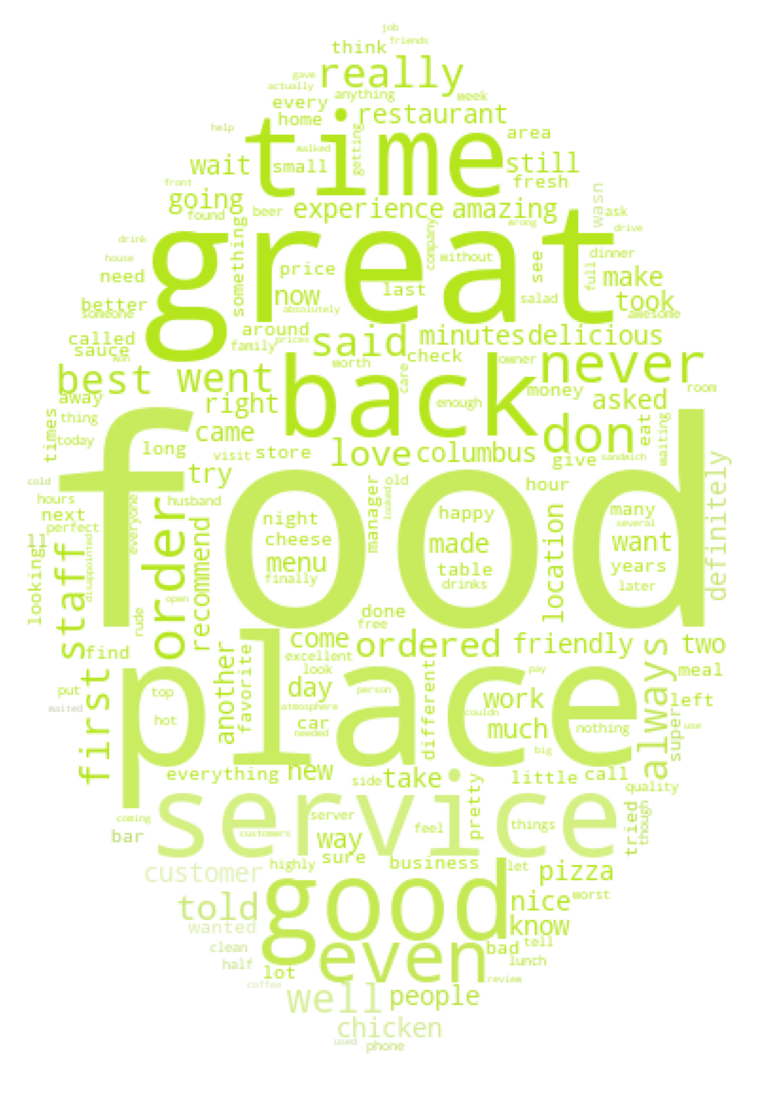

In [19]:
mask_colors = ImageColorGenerator(M)
wc = WordCloud(max_font_size=200,                 \
               max_words=200,                     \
               background_color="white",          \
               mask = M,                          \
               width = M.shape[1],                \
               height = M.shape[0],               \
               color_func = mask_colors).generate_from_frequencies(alldict)
    
plot_cloud(wc)
wc.to_file('Good_and_bad_M.png')

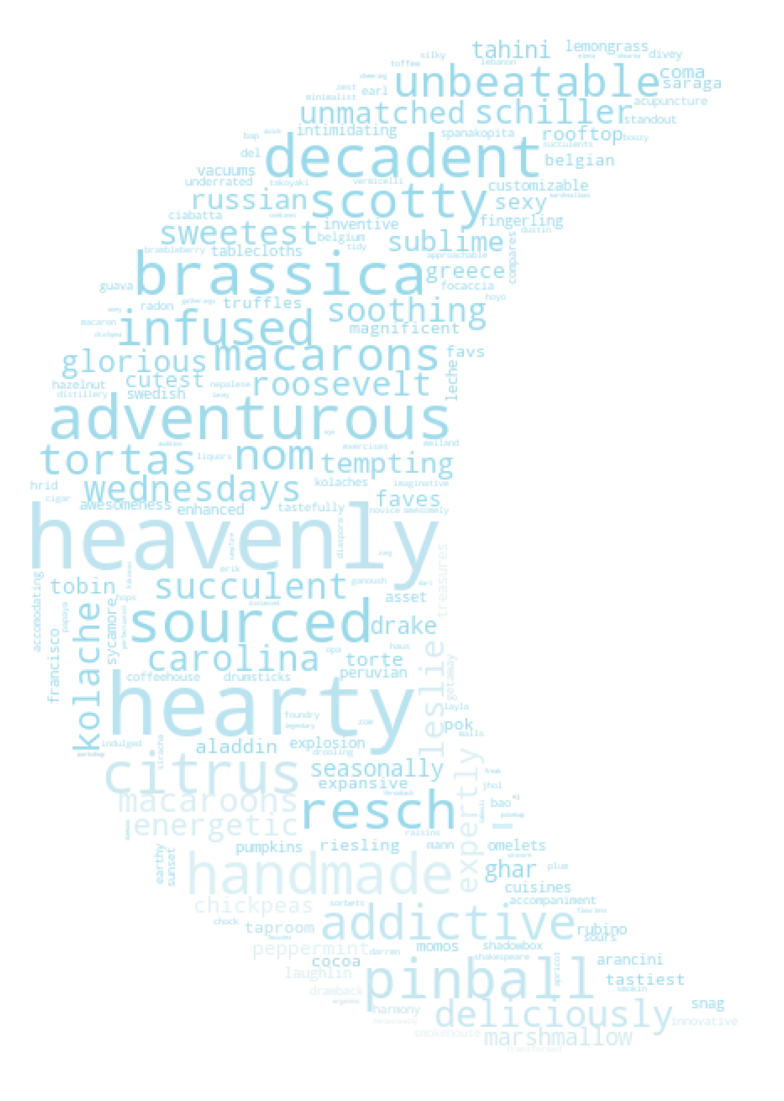

In [20]:
mask_colors = ImageColorGenerator(L)
wc = WordCloud(max_font_size=200,                 \
               max_words=200,                     \
               background_color="white",          \
               mask = L,                          \
               width = L.shape[1],                \
               height = L.shape[0],               \
               color_func = mask_colors).generate_from_frequencies(gnbdict)
    
plot_cloud(wc)
wc.to_file('Good_M.png')

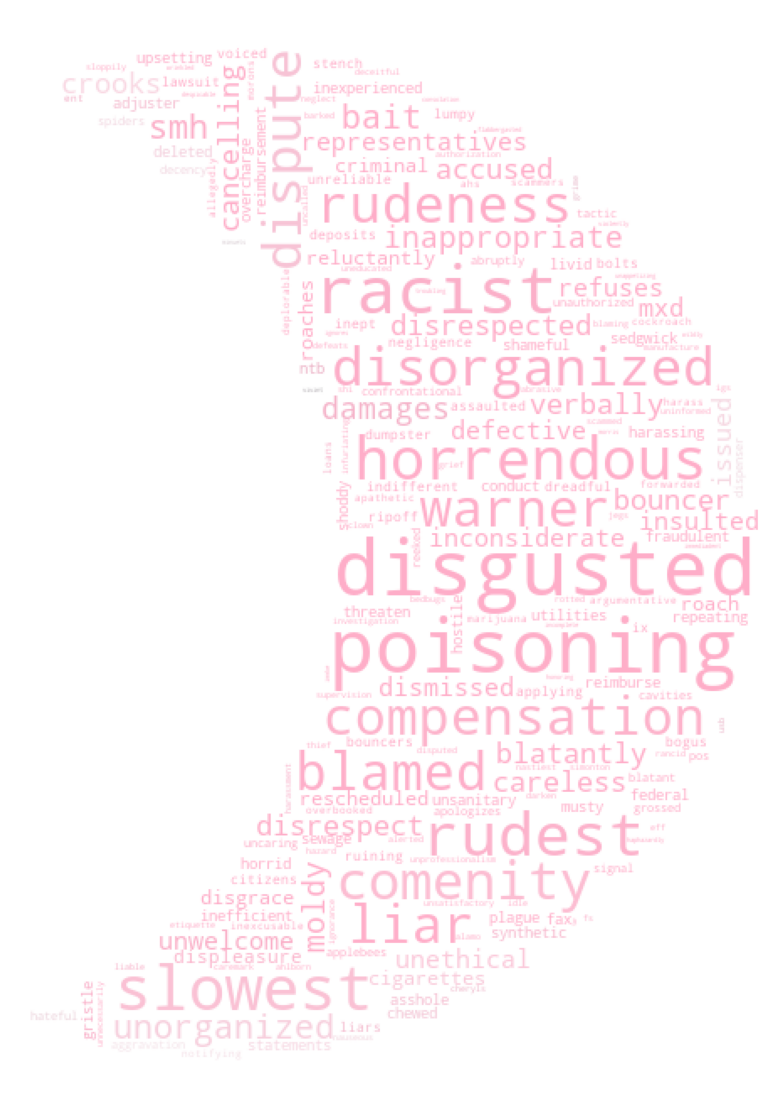

In [21]:
mask_colors = ImageColorGenerator(R)
wc = WordCloud(max_font_size=200,                 \
               max_words=200,                     \
               background_color="white",          \
               mask = R,                          \
               width = R.shape[1],                \
               height = R.shape[0],               \
               color_func=mask_colors).generate_from_frequencies(bngdict)
    
plot_cloud(wc)
wc.to_file('Bad_M.png')